In [15]:
import numpy as np
import matplotlib.pyplot as plt
import time
import pandas as pd
import pathlib

from tyssue.generation import generate_ring
from tyssue.draw.plt_draw import quick_edge_draw
from tyssue.solvers.sheet_vertex_solver import Solver
from tyssue.config.draw import sheet_spec
from tyssue.draw.plt_draw import sheet_view
from tyssue.io.hdf5 import save_datasets

from tyssue_taylor.adjusters.adjust_annular import set_init_point, prepare_tensions, adjust_tensions
from tyssue_taylor.models.annular import AnnularGeometry as geom
from tyssue_taylor.models.annular import model
from tyssue_taylor.adjusters.cost_functions import _distance
from tyssue_taylor.adjusters.force_inference import infer_forces
# from tyssue_taylor.segmentation.segment2D import generate_ring_from_image, normalize_scale


def normalize_scale(organo, geom):
    """Rescale an organo so that the mean cell area is close to 1.
    Useful if one as some issues with the scale of the optimization parameters.
    Parameters
    ----------
    organo : :class:`Epithelium` object
      the organo to rescale
    geom : tyssue geometry class
    Return
    ----------
    res_organo : :class:`Epithelium` object
      the rescaled organo
    """
    mean = organo.face_df.area.mean()
    organo.vert_df.loc[:, organo.coords] /= mean**0.5
    organo.settings['R_in'] /= mean**0.5
    organo.settings['R_out'] /= mean**0.5
    geom.update_all(organo)
    return organo

def get_sequence(seed, theta, shape):
    np.random.seed(seed)
    
    return np.random.normal(1.0, theta, shape)



Generate the theoritical organoïd

I'm putting here a list of remarks, all might not be related to the force infernce code

- maybe `normalize_scale` can be moved to `models.annular` as it is more a geometry than a segmentation thing

- Dans le texte théorique (qu'il faudra traduire en anglais et mettre dans la doc du projet):

> Bien que l’on puisse définir 2 ∗ N v contraintes grâce aux équation (2), un degré de liberté supplémentaire apparaı̂t car une variation uniforme des pressions P α , α ∈ {1, ..., N f + 2} ne change pas l’équilibre des forces, et donc ne modifie pas la forme des cellules.

Qu'entends-tu par «variation uniforme» ? Avec une multiplication ça va changer, pas en ajoutant une constante partout.


- Se serait bien d'écrire le cas général (sans hypothèse sur la relation entre Ne, Nf et Nv, et d'écrire la forme des matrices selon leur taille "naturelle" (Nf, Nv ou Ne selon le cas)


In [16]:
organo = generate_ring(10, 110, 150)
Nf= organo.Nf
geom.update_all(organo)
normalize_scale(organo, geom)
#alpha as proposed in the doc (in french) https://www.sharelatex.com/read/zdxptpnrryhc
alpha = 1 + 1/(20*(organo.settings['R_out']-organo.settings['R_in']))


# Model parameters or specifications
specs = {
    'face':{
        'is_alive': 1,
        'prefered_area':  alpha*organo.face_df.area, 
        'area_elasticity': 1.,},
    'edge':{        
        'ux': 0.,
        'uy': 0.,
        'uz': 0.,
        'line_tension': 0.1,
        'is_active': 1
        },
    'vert':{
        'adhesion_strength': 0.,
        'x_ecm': 0.,
        'y_ecm': 0.,
        'is_active': 1
        },
    'settings': {
        'lumen_elasticity': 0.1,
        'lumen_prefered_vol': organo.settings['lumen_volume'],
        'lumen_volume': organo.settings['lumen_volume']
        }
    }

organo.update_specs(specs, reset=True)
geom.update_all(organo)

symetric_tensions = np.multiply(set_init_point(organo.settings['R_in'], organo.settings['R_out'], organo.Nf, alpha),
                                np.random.normal(1,0.002,int(organo.Ne*0.75)))
sin_mul = 1+(np.sin(np.linspace(0, 2*np.pi, organo.Nf, endpoint=False)))**2
organo.face_df.prefered_area *= np.random.normal(1.0, 0.05, organo.Nf)
organo.edge_df.line_tension = prepare_tensions(organo, symetric_tensions)
organo.edge_df.loc[:Nf-1, 'line_tension'] *= sin_mul

organo.vert_df[['x_ecm', 'y_ecm']] = organo.vert_df[['x', 'y']]

organo.vert_df.loc[organo.basal_verts, 'adhesion_strength'] = 0.01

new_tensions = organo.edge_df.line_tension

organo.edge_df.loc[:,'line_tension'] = new_tensions
                                                          
res = Solver.find_energy_min(organo, geom, model)                                                       

Reseting datasets values with new specs


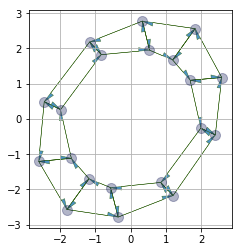

In [17]:
fig, ax = sheet_view(organo)

$$
\begin{eqnarray}
F^x_{ij} &= T_{ij}\frac{x_{ij}}{\ell_{ij}^2} + y_{ij}(P_a - P_b)\\
F^y_{ij} &= T_{ij}\frac{y_{ij}}{\ell_{ij}^2} - x_{ij}(P_a - P_b)\\
\end{eqnarray}
$$

In [18]:
from tyssue.utils import data_at_opposite

organo.get_opposite()
lumen_pressure = 10
outside_pressure = 5


# lets put random values for the values to infer
organo.edge_df['infered_tension'] = np.random.random(organo.Ne)
organo.face_df['infered_pressure'] = np.random.random(organo.Nf)

organo.edge_df['opposite_face'] = data_at_opposite(
    organo, organo.edge_df['face'], free_value=-1)

organo.edge_df['face_pressure'] = organo.upcast_face(organo.face_df['infered_pressure'])
organo.edge_df['oppo_pressure'] = data_at_opposite(
    organo, organo.edge_df['face_pressure'], free_value=lumen_pressure)


## index for the organoid exterior set to -2
organo.edge_df.loc[organo.basal_edges, 'opposite_face'] = -2
organo.edge_df.loc[organo.basal_edges, 'oppo_pressure'] = outside_pressure



tension_x = organo.edge_df.eval('infered_tension * dx / length**2')
tension_y = organo.edge_df.eval('infered_tension * dy / length**2')

laplace_x = organo.edge_df.eval('dy * (oppo_pressure - face_pressure)/2')
laplace_y = organo.edge_df.eval('-dx * (oppo_pressure - face_pressure)/2')




Dans le cas général, un vertex a trois voisins, avec (ou non) 2 demi-mailles entre eux:

```
       j
      ||
       i
    //  \\
    k    l
```

Pour l'instant on ne suppose pas que les tensions des 2 demi-mailles sont égales, on verra comment simplifier après.

On pose $u_{ij} = x_{ij}/\ell_{ij}^2, \quad v_{ij} = y_{ij}/\ell_{ij}^2$,

L'équation pour la position en $x$ du vertex $i$ s'écrit à la ligne $i$: 

$$\sum_j F^x_{ij} = 0 \Leftrightarrow 
   T_{ij}u_{ij} - T_{ji}u_{ji}
 + T_{ik}u_{ik} - T_{ki}u_{ki}
 + T_{il}u_{ij} - T_{li}u_{li} = 0$$
 
Pour $y_i$ à la ligne $i + N_v$: 

$$\sum_j F^x_{ij} = 0 \Leftrightarrow 
   T_{ij}v_{ij} - T_{ji}v_{ji}
 + T_{ik}v_{ik} - T_{ki}v_{ki}
 + T_{il}v_{ij} - T_{li}v_{li} = 0$$
 
On ajoute à la ligne $N_v$ la contrainte sur la somme des tensions:
$\sum_{ij} T_{ij} = 1$
 
Le système linéaire a $2N_v + 1$ équations et $N_e$ inconnues.


[[-0.59382897  0.          0.         ...  0.          0.
   0.        ]
 [ 0.59382897 -0.99463053  0.         ...  0.          0.
   0.        ]
 [ 0.          0.99463053 -0.92501244 ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ...  0.         -0.81107622
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
  -0.084806  ]
 [ 1.          1.          1.         ...  1.          1.
   1.        ]]


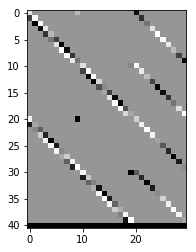

In [27]:
from scipy import sparse ## See relevant doc

## This needs to be done only at initialisation
## Or when the topology changes
organo.get_extra_indices()

def coef_matrix(organo):
    
    u_ij = organo.edge_df.eval('dx / length')
    v_ij = organo.edge_df.eval('dy / length')
    uv_ij = np.concatenate((u_ij, v_ij))

    A_shape = (2*organo.Nv+1, organo.Ne)
    srce_rows = np.concatenate([
        organo.edge_df.srce,              ## x lines
        organo.edge_df.srce + organo.Nv   ## y lines
    ])

    trgt_rows = np.concatenate([
        organo.edge_df.trgt,              ## x lines
        organo.edge_df.trgt + organo.Nv   ## y lines
    ])

    cols = np.r_[:organo.Ne, :organo.Ne] ## [0 ... Ne, 0 ... Ne]

    A_srce = sparse.coo_matrix((uv_ij, (srce_rows, cols)), shape=A_shape)
    A_trgt = sparse.coo_matrix((-uv_ij, (trgt_rows, cols)), shape=A_shape)
    # Ones every where on the last line
    A_sumT = sparse.coo_matrix(
        (np.ones(organo.Ne), 
         (np.ones(organo.Ne)*2*organo.Nv, 
          np.arange(organo.Ne))), shape=A_shape)

    A = A_srce + A_trgt + A_sumT

    # As tensions are equal for edge pairs, we can solve for only 
    # the single edges. An index over only one half-edge per edge
    # can be obtained with:

    A = A[:, organo.sgle_edges]

    return A

A = coef_matrix(organo)
fig, ax = plt.subplots()
ax.imshow(A.toarray(), cmap='Greys')
print(A.toarray())

In [30]:
organo.sgle_edges

Int64Index([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
            17, 18, 19, 20, 21, 22, 23, 24, 34, 35, 36, 37, 38],
           dtype='int64', name='edge')

### Comparison with the original implementation

[[-0.59382897  0.          0.         ...  0.          0.
   0.        ]
 [ 0.59382897 -0.99463053  0.         ...  0.          0.
   0.        ]
 [ 0.          0.99463053 -0.92501244 ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ...  0.         -0.81107622
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
  -0.084806  ]
 [ 1.          1.          1.         ...  1.          1.
   1.        ]]


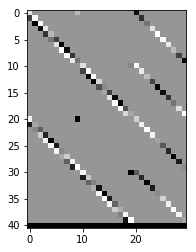

In [26]:
from tyssue_taylor.adjusters.force_inference import _coef_matrix

original_A = _coef_matrix(organo, compute_pressions=False)
print(original_A)
fig, ax = plt.subplots()
ax.imshow(original_A, cmap='Greys')

In [11]:
%timeit coef_matrix(organo)

3.7 ms ± 23.4 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [12]:
%timeit _coef_matrix(organo)

40 ms ± 225 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [9]:
# All the coeffs of both matrices have the same sign
# but they differ in values, IDK where this comes from

np.all(np.sign(original_A) == np.sign(A.toarray()))

True

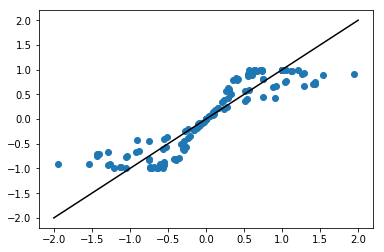

In [10]:
fig, ax = plt.subplots()
ax.plot(A.toarray().ravel(), original_A.ravel(), 'o')
ax.plot(np.linspace(-2, 2), np.linspace(-2, 2), 'k-')